# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
pd.options.display.max_columns = 100

**Описание данных**

+ Name — название игры
+ Platform — платформа
+ Year_of_Release — год выпуска
+ Genre — жанр игры
+ NA_sales — продажи в Северной Америке (миллионы долларов)
+ EU_sales — продажи в Европе (миллионы долларов)
+ JP_sales — продажи в Японии (миллионы долларов)
+ Other_sales — продажи в других странах (миллионы долларов)
+ Critic_Score — оценка критиков (максимум 100)
+ User_Score — оценка пользователей (максимум 10)
+ Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.columns =  games.columns.str.lower()
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Шаг 2. Подготовьте данные**

+ Замените названия столбцов (приведите к нижнему регистру);
+ Преобразуйте данные в нужные типы. 
+ Опишите, в каких столбцах заменили тип данных и почему;
+ Обработайте пропуски при необходимости:
+ Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
+ Опишите причины, которые могли привести к пропускам;
+ Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать;
+ Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [3]:
have_nan =[]
for col in games.columns:
    if games[col].isna().sum() > 0:
        have_nan.append([col,round(games[col].isna().sum() / len(games),4), games[col].isna().sum()])      
        
print('Проблемы в',len(have_nan), 'столбцах')
# проверяем пропуски и дубликаты 
print('Кол-во пропусков = {:.0f}'.format(games.isna().sum().sum() ) )
print('Кол-во дублей = {:.0f}'.format(games.duplicated().sum() ) )

have_nan = pd.DataFrame(have_nan)
have_nan.columns = ['Field','Part_of_sample','Total_count']
have_nan.sort_values('Part_of_sample', ascending = False, inplace = True)

print('----------Доля пропусков -----------')
print(have_nan)

Проблемы в 6 столбцах
Кол-во пропусков = 22318
Кол-во дублей = 0
----------Доля пропусков -----------
             Field  Part_of_sample  Total_count
3     critic_score          0.5132         8578
5           rating          0.4048         6766
4       user_score          0.4009         6701
1  year_of_release          0.0161          269
0             name          0.0001            2
2            genre          0.0001            2


In [4]:
# пропуски по годам выпуска заменим на 1950 для удобства и заменим тип на целочисленный, т.к.это год
games.loc[games['year_of_release'].isna(),'year_of_release'] = 1950
games['year_of_release'] = games['year_of_release'].astype(int)

In [5]:
# пропуски по названию и жанру заменим на EMPTY текст
games.loc[games['name'].isna(),'name']  = 'EMPTY'
games.loc[games['genre'].isna(),'genre']  = 'EMPTY'

Остались пропуски в трех полях **critic_score, rating, user_score**  они содержат в себе основополагающие метрики которые нельзя заменить медианой, средним и прочими константами, т.к. это империческая оценка качества

In [6]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

+ «EC» («Early childhood») — «Для детей младшего возраста»:
+ «E» («Everyone») — «Для всех»
+ «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»:
+ «T» («Teen») — «Подросткам»:
+ «M» («Mature») — «Для взрослых»:
+ «AO» («Adults Only 18+») — «Только для взрослых»:
+ «RP» («Rating Pending») — «Рейтинг ожидается»:
+ «K-A» ("Kids to Adults") - аналог «E»

In [7]:
#подсчитаем итоговый доход по игре
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

### Шаг 3. Проведите исследовательский анализ данных
+ Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
+ Посмотрите, как менялись продажи по платформам. 
+ Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
+ Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.Не учитывайте в работе данные за предыдущие годы.
+ Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
+ Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
+ Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
+ Соотнесите выводы с продажами игр на других платформах.
+ Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [8]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


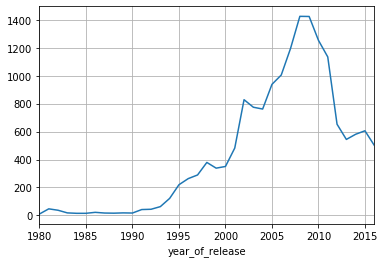

In [9]:
#Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
games[games['year_of_release']!= 1950].groupby('year_of_release')['name'].count().plot(grid = True)

#видим в 2009 резкий провал, может он связан с прекращением выпуска игр на определенную платформу?

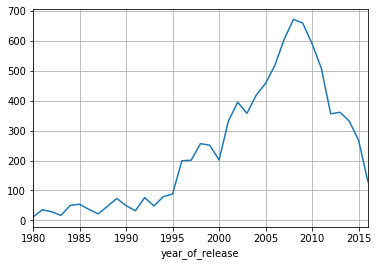

In [10]:
# прибыль от продаж соответствует кол-ву игр
games[games['year_of_release']!= 1950].groupby('year_of_release')['total_sales'].sum().plot(grid = True)

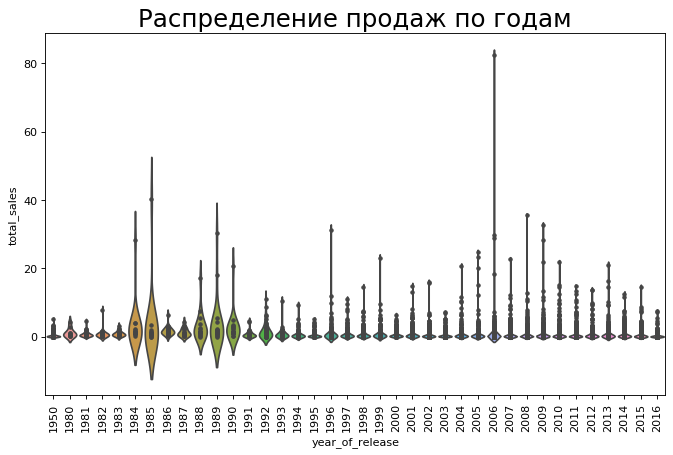

In [11]:
# Видим что в 2006 произошло нечто значительное по продажам! (Выход на рынок Wii)
# Так же на графике видно что в последующие года выпускались единичные кассовые игры,

plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(x='year_of_release', y='total_sales', data=games, scale='width', inner='point')
plt.xticks(rotation=90)

plt.title('Распределение продаж по годам', fontsize=22)
plt.show()

In [12]:
# В 2006 гигантские продажи именно по Wii, на таблице игры с максимальной прибылью
# PS3 и X360 наращивают темп, но у  Wii другая стратегия - новый манипулятор 
games.query('2006 <= year_of_release <= 2009').pivot_table(index = 'platform', values = 'total_sales', columns = 'year_of_release', aggfunc = ('max')).fillna(0)


year_of_release,2006,2007,2008,2009
platform,,,,
DC,0.00,0.02,0.04,0.00
DS,29.80,8.91,7.71,11.77
GBA,1.13,1.76,0.00,0.00
GC,1.59,0.14,0.00,0.00
PC,0.51,4.09,1.32,8.01
PS2,5.95,4.99,2.51,2.22
PS3,4.35,6.68,10.50,10.61
PSP,5.03,3.75,5.49,3.26
Wii,82.54,22.70,35.52,32.77


/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


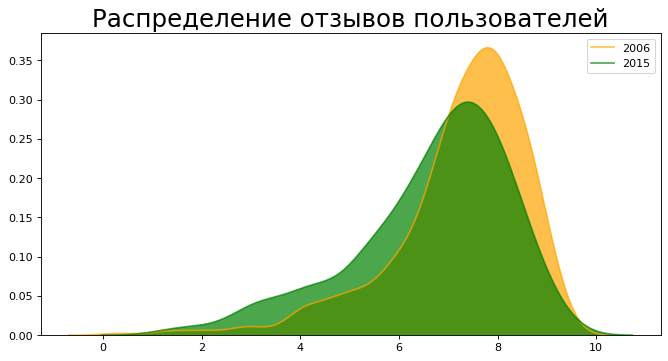

In [13]:
# Draw Plot
plt.figure(figsize=(10,5), dpi= 80)
sns.kdeplot(games.loc[(games['year_of_release'] == 2006) & (games['user_score'] != 'tbd'), "user_score"], shade=True, color="orange", label="2006", alpha=.7)
sns.kdeplot(games.loc[(games['year_of_release'] == 2015) & (games['user_score'] != 'tbd'), "user_score"], shade=True, color="g", label="2015", alpha=.7)
# Decoration
plt.title('Распределение отзывов пользователей', fontsize=22)
plt.legend()
plt.show()

# видно что в 2006 отзывы намного выше чем например в 2015, это был WOW эффект на рынке

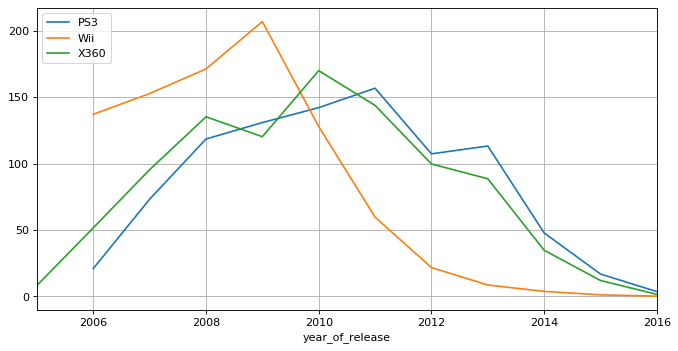

In [14]:
# Стремительный взлет Wii и такое же падение спроса на фоне Xbox 360/PS3

# Wii сделали упор на новизну общения с пользователем и не заморочились с железом
# Ее стремительный успех был обрушен выводом на рынок кинетика от Xbox и аналогичного манипулятора у Sony
# Плюсом у них было значительно лучше железо

# Еще здесь также видна жизнь консоли в годах, подъем продаж и спад в среднем за ~ 8 лет

plt.figure(figsize=(10,5), dpi= 80)
games.query('year_of_release!= 1950 and platform == "PS3"').groupby('year_of_release')['total_sales'].sum().plot( grid = True)
games.query('year_of_release!= 1950 and platform == "Wii"').groupby('year_of_release')['total_sales'].sum().plot(grid = True)
games.query('year_of_release!= 1950 and platform == "X360"').groupby('year_of_release')['total_sales'].sum().plot(grid = True)
plt.legend(('PS3','Wii' ,'X360'), ncol=1, loc='upper left');

In [15]:
#Посмотрите, как менялись продажи по платформам.
# Ожидаемо мы видим просадку по всем платформу в части выручки, она безусловно кореллирует с данными по выпускам игр

# for console in games['platform'].unique():
#         if len(games[(games['year_of_release']>= 2007) & (games['platform'] ==console)]) > 0:
#             print('-------',console,'-------')
#             games[(games['year_of_release']>= 2007) & (games['platform']==console)].groupby('year_of_release')['total_sales'].sum().plot(kind = 'bar',grid = True)
#             plt.show()


In [16]:
# Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. 
# За какой характерный срок появляются новые и исчезают старые платформы?

In [17]:
games.pivot_table(index = 'platform', values='total_sales', aggfunc = ('count','mean','median','sum')).sort_values(by = 'sum', ascending = False).head(10)

,count,mean,median,sum
platform,,,,
PS2,2161,0.581106,0.23,1255.77
X360,1262,0.769746,0.28,971.42
PS3,1331,0.705973,0.27,939.65
Wii,1320,0.687508,0.19,907.51
DS,2151,0.374765,0.11,806.12
PS,1197,0.610576,0.26,730.86
GBA,822,0.386679,0.16,317.85
PS4,392,0.801378,0.20,314.14
PSP,1209,0.243218,0.09,294.05


In [18]:
console_lifetime = games[(games['year_of_release'] != 1950) ].pivot_table(index = 'platform', values='year_of_release', aggfunc = (['min','max']))
console_lifetime.reset_index(inplace = True)
console_lifetime.columns = ['platfrom','start','finish']
console_lifetime['Year_count'] = console_lifetime['finish'] - console_lifetime['start']
# исключаем новые платформы и PC
console_filter = ['XOne','PC', 'PS4','WiiU']
print('Среднее время жизни консоли',round(console_lifetime.query('@console_filter not in platfrom')['Year_count'].mean(),2) , 'лет')

Среднее время жизни консоли 7.22 лет


In [19]:
console_lifetime

,platfrom,start,finish,Year_count
0,2600,1980,1989,9
1,3DO,1994,1995,1
2,3DS,2011,2016,5
3,DC,1998,2008,10
4,DS,1985,2013,28
5,GB,1988,2001,13
6,GBA,2000,2007,7
7,GC,2001,2007,6
8,GEN,1990,1994,4
9,GG,1992,1992,0


**Возьмите данные за соответствующий актуальный период**. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.Не учитывайте в работе данные за предыдущие годы.

In [20]:
print('Актуальный год -',games['year_of_release'].unique().max())
# обрезаем данные по 2016 год
games_only_2016 = games[games['year_of_release']==games['year_of_release'].unique().max()]

Актуальный год - 2016


Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [21]:
# моя гипотеза - данные за 2016 не полные, значит для аналитики брем динамику 2014 к 2015
year_filter = [2014,2015,2016]
games.query('@year_filter in year_of_release').pivot_table(index = 'platform',columns = 'year_of_release', values = 'total_sales', aggfunc = ('sum'))


year_of_release,2014,2015,2016
platform,,,
3DS,43.76,27.78,15.14
PC,13.28,8.52,5.25
PS3,47.76,16.82,3.60
PS4,100.00,118.90,69.25
PSP,0.24,0.12,NaN
PSV,11.90,6.25,4.25
Wii,3.75,1.14,0.18
WiiU,22.03,16.35,4.60
X360,34.74,11.96,1.52


In [22]:
# собственно гипотеза подтверждается - виден прирост 2014/2015 по флагманам PS4 и XOne (18 и 11 % соответственно)
(games.query('year_of_release == 2015').groupby('platform')['total_sales'].sum() / games.query('year_of_release == 2014').groupby('platform')['total_sales'].sum()).sort_values(ascending = False)

platform
PS4     1.189000
XOne    1.112262
WiiU    0.742170
PC      0.641566
3DS     0.634826
PSV     0.525210
PSP     0.500000
PS3     0.352178
X360    0.344272
Wii     0.304000
Name: total_sales, dtype: float64

Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

In [23]:
game_agg = games.groupby('name')['platform'].count()
game_agg = pd.DataFrame(game_agg)
game_agg.reset_index(inplace = True)

game_agg.head()


,name,platform
0,Beyblade Burst,1
1,Fire Emblem Fates,1
2,Frozen: Olaf's Quest,2
3,Haikyu!! Cross Team Match!,1
4,Tales of Xillia 2,1


In [24]:
# Посмотрим детальные продажи по играм
name_filter = game_agg.query('platform >=8')['name'].values.tolist()
game_data = games.query('@name_filter in name').pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = ('sum')).fillna(0)
game_data

platform,3DS,DS,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
name,,,,,,,,,,,,,,,,,
Angry Birds Star Wars,0.33,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.29,0.22,0.00,0.08,0.26,0.10,0.28,0.00,0.17
Cars,0.00,0.96,1.13,0.94,0.00,0.00,0.0,1.21,0.00,0.00,1.20,0.00,0.93,0.00,0.25,0.20,0.00
FIFA 14,0.23,0.00,0.00,0.00,0.00,0.40,0.0,0.00,6.46,3.01,0.19,0.41,0.38,0.00,4.22,0.00,1.16
FIFA 15,0.46,0.00,0.00,0.00,0.00,0.29,0.0,0.00,4.28,6.08,0.00,0.60,0.56,0.00,2.92,0.00,2.18
FIFA Soccer 13,0.29,0.00,0.00,0.00,0.00,0.40,0.0,0.00,8.17,0.00,0.34,0.44,0.69,0.48,5.16,0.00,0.00
LEGO Harry Potter: Years 5-7,0.40,0.66,0.00,0.00,0.00,0.22,0.0,0.00,0.92,0.00,0.26,0.17,1.23,0.00,0.97,0.00,0.00
LEGO Jurassic World,0.62,0.00,0.00,0.00,0.00,0.04,0.0,0.00,0.85,0.90,0.00,0.23,0.00,0.52,0.87,0.00,0.66
LEGO Marvel Super Heroes,0.89,0.38,0.00,0.00,0.00,0.17,0.0,0.00,1.83,1.62,0.00,0.51,0.00,0.74,2.22,0.00,1.05
LEGO Star Wars II: The Original Trilogy,0.00,1.07,0.08,0.97,0.00,0.01,0.0,2.69,0.00,0.00,1.40,0.00,0.00,0.00,0.63,0.45,0.00


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

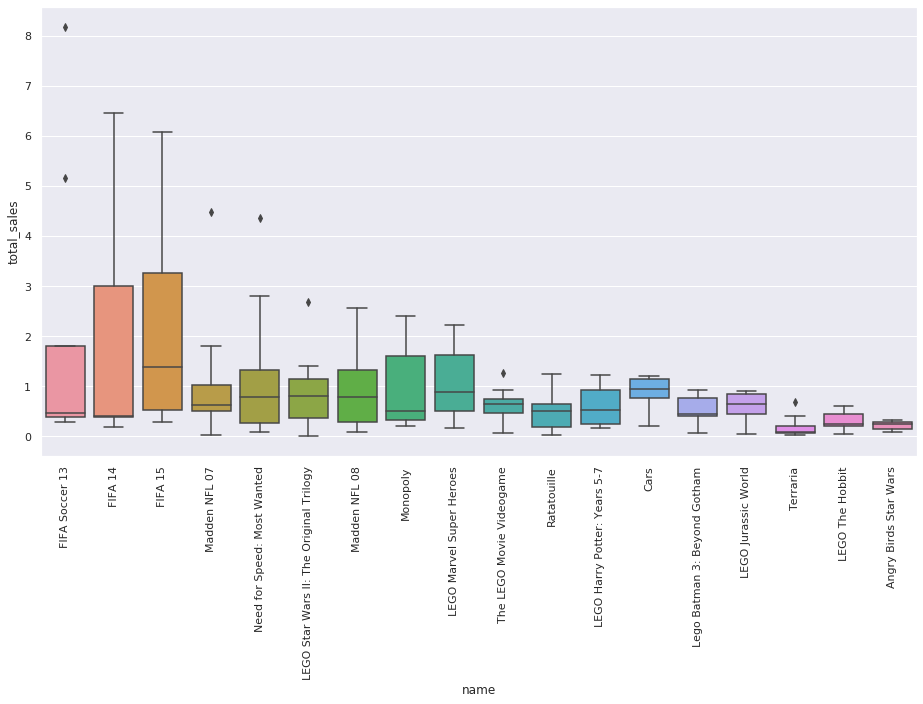

In [25]:
# Самые продаваемые многоплатформенные игры это Fifa 2014/2015 в частности, и спортивные игры в общем
# Electronic arts знает толк в годном контенте!
import seaborn as sns

name_filter = game_agg.query('platform >=8')['name'].values.tolist()
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.boxplot(x="name", y="total_sales", data=games.query('@name_filter in name'))
plt.xticks(rotation=90)

In [26]:
# А в средних продажах на разных платформах? Опишите результат.
games.groupby('platform')['total_sales'].mean().sort_values(ascending = False).head(5)

# В топе средний чек по играм для консолей первых поколений, т.к. по сути они "драйвили" рынок игр 
# всеми нами любимый Dendy, Sega Mega Drive

platform
GB      2.606735
NES     2.561735
GEN     1.061034
SNES    0.836987
PS4     0.801378
Name: total_sales, dtype: float64

Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
Соотнесите выводы с продажами игр на других платформах.

In [27]:
# Посчитаем кол-во tbd в user_score
print('Кол-во  tbd - ',games.query('user_score == "tbd"').shape[0])

Кол-во  tbd -  2424


In [28]:
games_without_tbd = games.query('user_score != "tbd"')
games_without_tbd['user_score'] = pd.to_numeric(games_without_tbd['user_score'],errors='coerce')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
# кореляция user_score VS critic_score = 0.58
# это считается средней связью, за неимением другого будем использовать ее
# для восстановения user_score 

games_without_tbd[['user_score','critic_score']].corr()

,user_score,critic_score
user_score,1.000000,0.580878
critic_score,0.580878,1.000000


In [30]:
user_score_dict = pd.DataFrame(games_without_tbd.groupby('critic_score')['user_score'].mean())
user_score_dict.reset_index(inplace = True)

In [31]:
games = games.merge(user_score_dict, on = 'critic_score', suffixes = ('','_old'), how = 'left')
games.loc[games['user_score']=='tbd','user_score'] = games['user_score_old']
del games['user_score_old']
games['user_score'] = pd.to_numeric (games['user_score'],errors='coerce')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


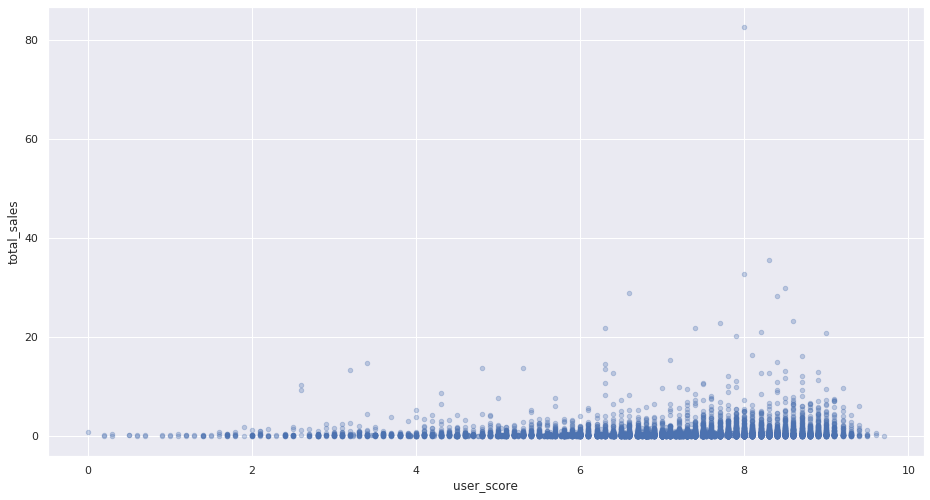

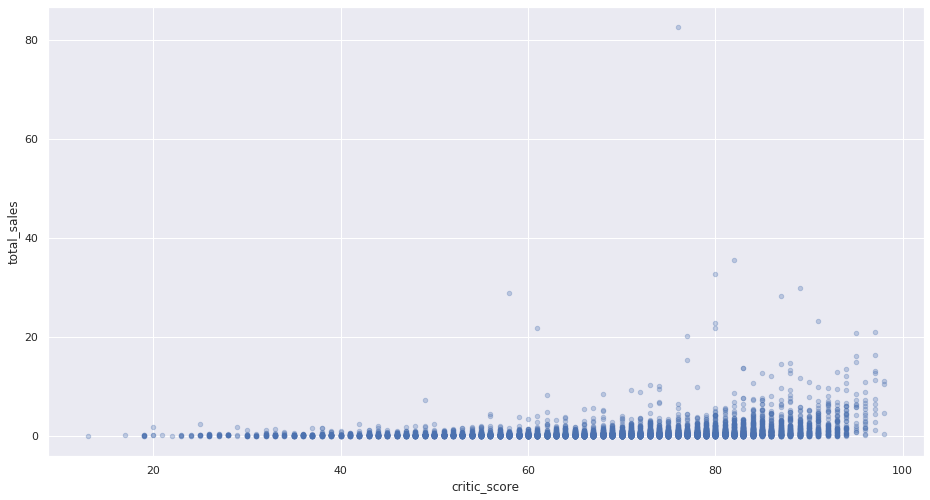

In [32]:
#Чем выше рейтинги - тем больше продаж

games.plot(x ='user_score', 
           y = 'total_sales', 
           kind = 'scatter',
                      alpha=0.3)

games.plot(x ='critic_score', 
           y = 'total_sales', 
           kind = 'scatter',
                      alpha=0.3)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


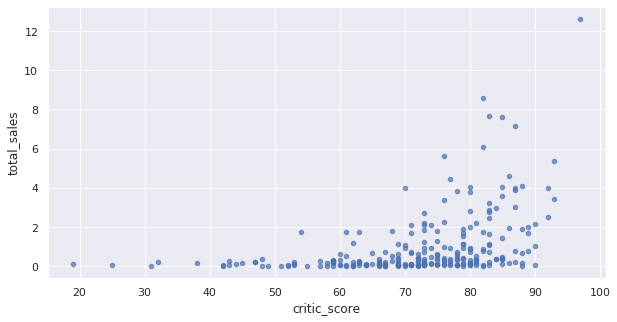

In [33]:
# возьмем самую динамичную платформу PS4     
# Чем выше рейтинг критиков  тем больше доход с продаж - очевидно
games[(~games['critic_score'].isna() & (games['platform']=='PS4') )].plot(x = 'critic_score', y = 'total_sales', alpha = 0.7, kind = 'scatter',  grid = True, figsize = (10,5))

--------------------------- Action ------------------------------------


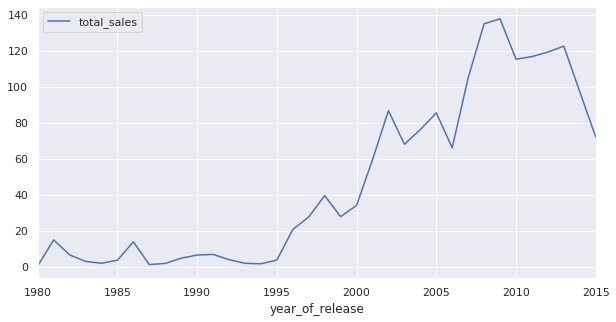

--------------------------- Adventure ------------------------------------


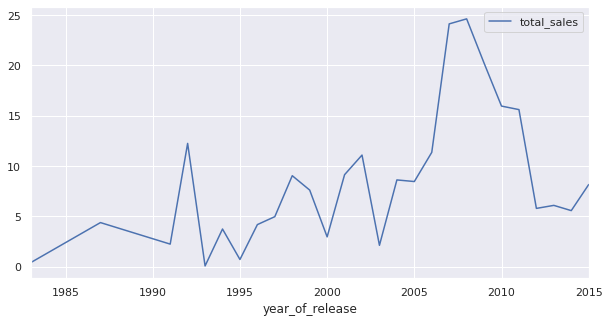

--------------------------- Fighting ------------------------------------


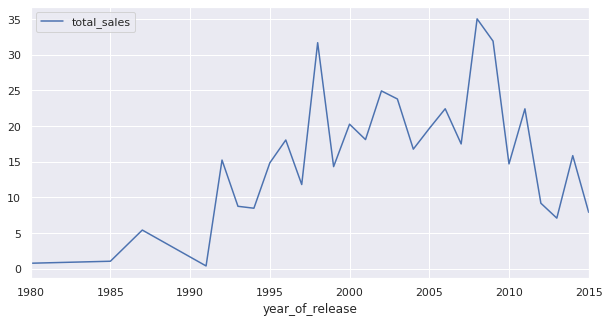

--------------------------- Misc ------------------------------------


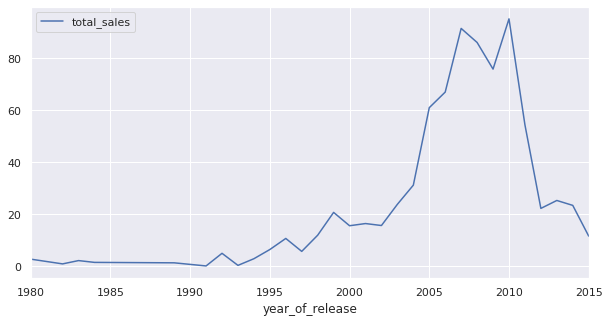

--------------------------- Platform ------------------------------------


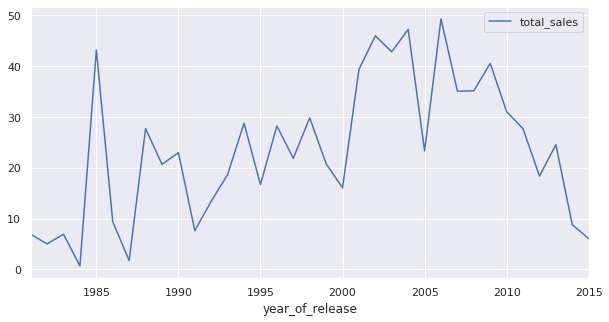

--------------------------- Puzzle ------------------------------------


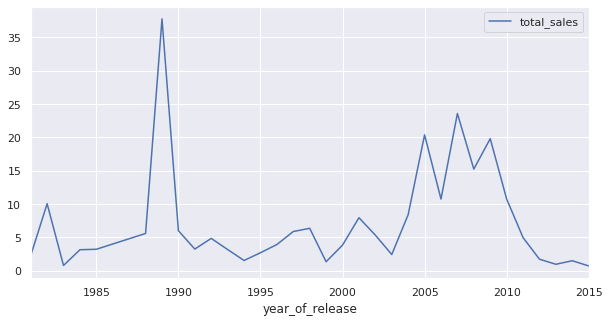

--------------------------- Racing ------------------------------------


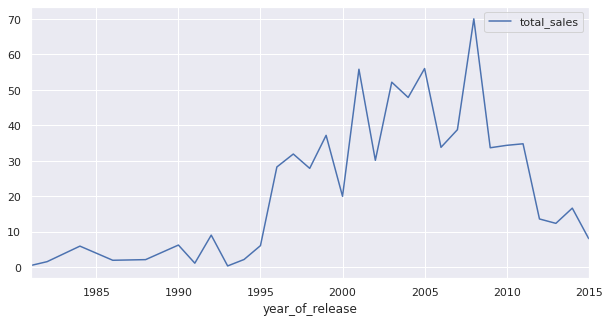

--------------------------- Role-Playing ------------------------------------


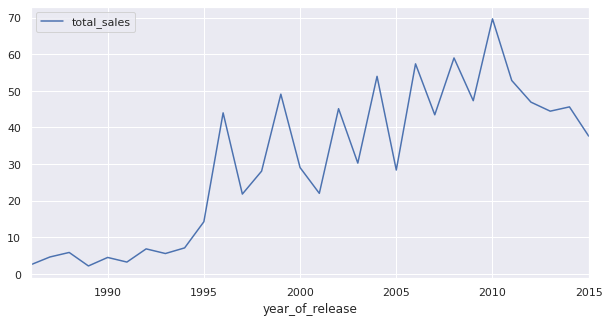

--------------------------- Shooter ------------------------------------


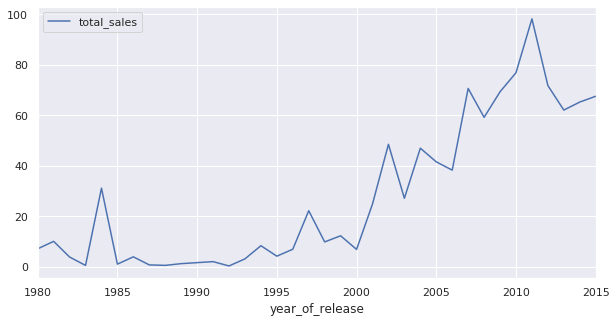

--------------------------- Simulation ------------------------------------


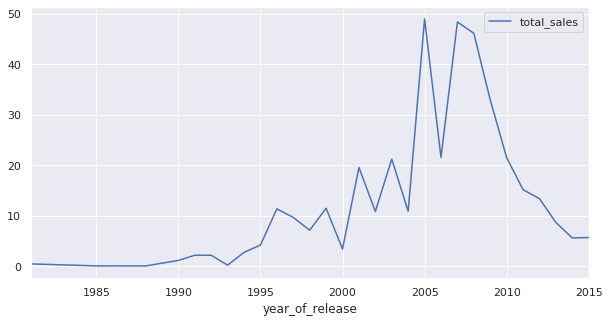

--------------------------- Sports ------------------------------------


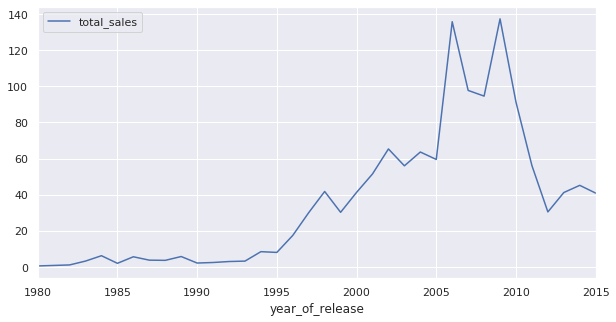

--------------------------- Strategy ------------------------------------


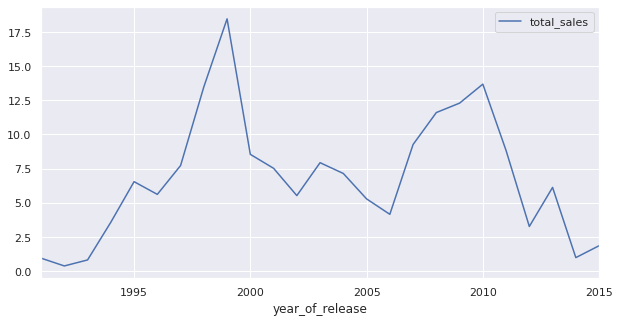

In [34]:
sns.set(rc={'figure.figsize':(10,5)})

genre_analize = games.query('year_of_release != 1950 and genre != "EMPTY" and year_of_release != 2016').pivot_table(index = ('genre','year_of_release'), values = 'total_sales', aggfunc = ('sum') ).fillna(0)
genre_analize = pd.DataFrame(genre_analize)
genre_analize.reset_index(inplace = True)

for genre_game in genre_analize['genre'].unique():
    print('---------------------------',genre_game,'------------------------------------')
    genre_analize[genre_analize['genre']==genre_game].plot(x = 'year_of_release', y = 'total_sales')
    plt.show()

# Рост продаж 2014-2015  виден только по 
# Shoote
# Adventure
# Strategy

Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

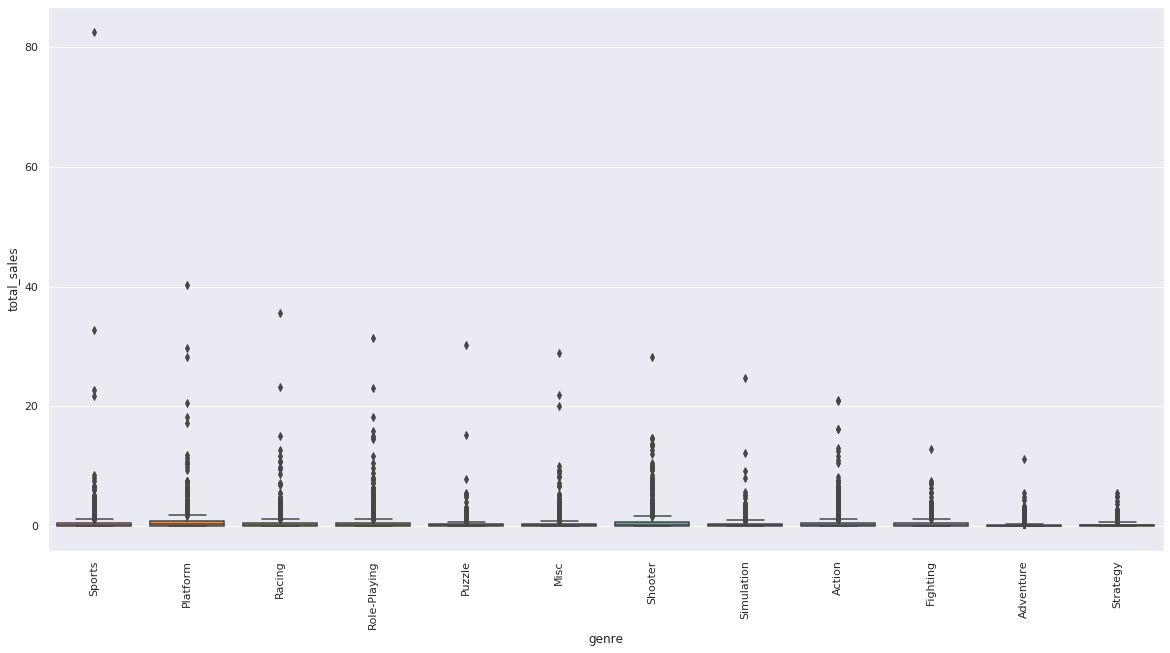

In [35]:
# самые продаваемые жанры это спорт, гонки и платформеры
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(x="genre", y="total_sales", data=games.query('genre != "EMPTY"'))
plt.xticks(rotation=90)

# Выводы по исследованию (шаг №3)


- Видим в 2009 резкий провал,судя по всему началось значительное сокращение выпуска игр для: 
  Nintendo Wii и DS и старой линейки флагманов Sony PlayStation (PSP, PSP2, PSP3) и Microsoft Xbox (X360)
- Ожидаемо мы видим просадку по всем платформу в части выручки, она безусловно кореллирует с данными по выпускам игр
- Среднее время жизни консоли 7.22 лет
- Актуальный год - 2016
- Виден прирост продаж 2014/2015 по флагманам PS4 и XOne (18 и 11 % соответственно)
- Самые продаваемые многоплатформенные игры это Fifa 2014/2015
- В топе средний чек по играм для консолей первых поколений, т.к. по сути они "драйвили" рынок игр 
  (всеми любимый Dendy, Sega Mega Drive)
- Чем выше рейтинги - тем больше продаж, корреляция рейтингов критиков и пользоватлей =  0.58 (средняя)
- Рост продаж 2014-2015  виден только по жанрам (Shooter, Adventure, Strategy)
- Cамые продаваемые жанры это спорт, гонки и платформеры

**Шаг 4. Составьте портрет пользователя каждого региона**

Определите для пользователя каждого региона (NA, EU, JP):

- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [36]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [37]:
# Определим топ продаж по играм в странах
# кто больше собрал тот и считается победителем
def find_top(row):
    winner = 'EMPTY'
    if row['na_sales'] > row['eu_sales'] and row['na_sales'] > row['jp_sales'] and row['na_sales'] > row['other_sales']:
        winner = 'USA'
    
    if row['eu_sales'] > row['na_sales'] and row['eu_sales'] > row['jp_sales'] and row['eu_sales'] > row['other_sales']:
        winner = 'Europe'
    
    if row['jp_sales'] > row['na_sales'] and row['jp_sales'] > row['eu_sales'] and row['jp_sales'] > row['other_sales']:
        winner = 'Japan'
    
    
    
    return winner

In [38]:
games['top_sales'] = games.apply(find_top, axis=1)

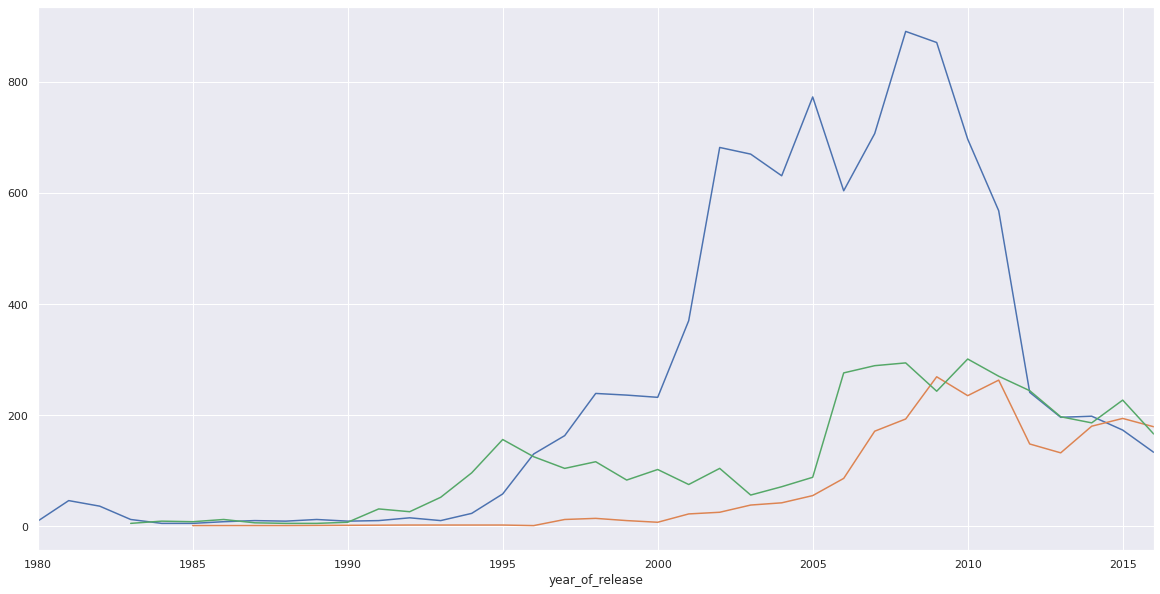

In [39]:
# Продажи в Северной Америке значительно превосходят другие регионы иммено с точки зрения доли в разрезе игр,
# т.е. там более охотно скупают игры

games.query('top_sales == "USA" and year_of_release != 1950').groupby('year_of_release')['year_of_release'].count().plot()
games.query('top_sales == "Europe" and year_of_release != 1950').groupby('year_of_release')['year_of_release'].count().plot()
games.query('top_sales == "Japan" and year_of_release != 1950').groupby('year_of_release')['year_of_release'].count().plot()


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

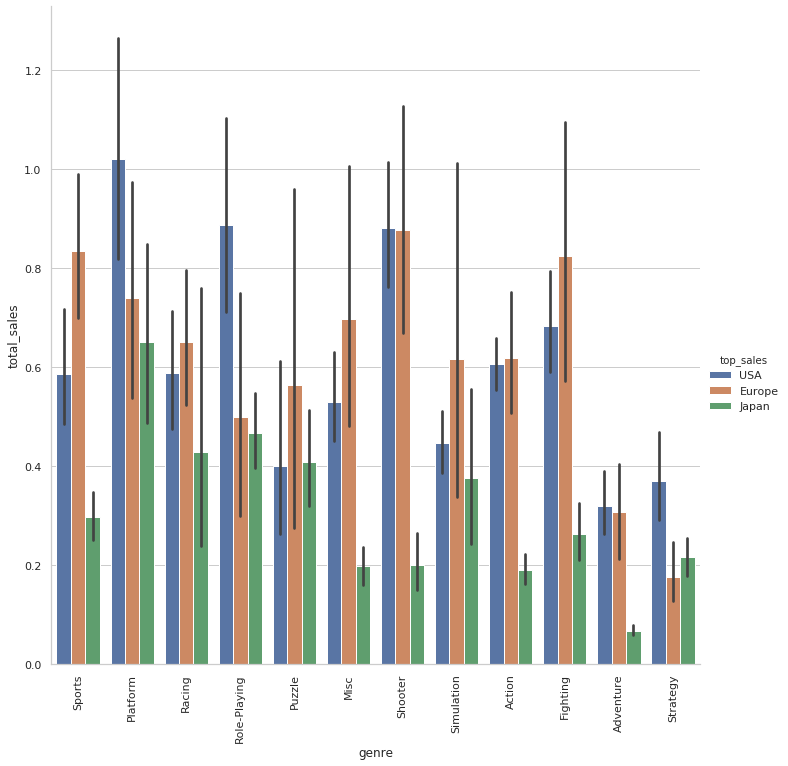

In [40]:
# посмотрим как выглядит распределение по жанрам и играм, которые были лидерами в доле в стране

sns.set(style="whitegrid")
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
g = sns.catplot(x="genre", y="total_sales", hue="top_sales", data=games.query('top_sales != "EMPTY" and year_of_release != 1950 and genre != "EMPTY"'),
                height=10, kind="bar")
plt.xticks(rotation=90)

In [41]:
na_market = games.pivot_table(index = 'platform', values= 'na_sales', aggfunc = ('sum')).sort_values(by = 'na_sales',ascending = False).head()
eu_market = games.pivot_table(index = 'platform', values= 'eu_sales', aggfunc = ('sum')).sort_values(by = 'eu_sales',ascending = False).head()
jp_market = games.pivot_table(index = 'platform', values= 'jp_sales', aggfunc = ('sum')).sort_values(by = 'jp_sales',ascending = False).head()

na_market.reset_index(inplace = True)
eu_market.reset_index(inplace = True)
jp_market.reset_index(inplace = True)

na_market['na_sales'] = na_market['na_sales'] / na_market['na_sales'].sum()
eu_market['eu_sales'] = eu_market['eu_sales'] / eu_market['eu_sales'].sum()
jp_market['jp_sales'] = jp_market['jp_sales'] / jp_market['jp_sales'].sum()

print('------ na_market------')
print(na_market.head())

print('------ eu_market------')
print(eu_market.head())

print('------ jp_market------')
print(jp_market.head())

# здесь мы отчетливо наблюдаем популярность xbox  в Северной Америке, оно и понятно Microsoft рядом
# Европа предпочитает продукт Sony,  но и xbox немного уступает конкуренту ps3
# Рынок Японии весьма специфичен, лидируют карманная консоль ds +  в почете свой продукт от Sony. 
# Удивительно, но в топ-5 в Японии нет xbox!

------ na_market------
  platform  na_sales
0     X360  0.244996
1      PS2  0.237420
2      Wii  0.202066
3      PS3  0.160014
4       DS  0.155504
------ eu_market------
  platform  eu_sales
0      PS2  0.239585
1      PS3  0.233229
2     X360  0.191193
3      Wii  0.185156
4       PS  0.150837
------ jp_market------
  platform  jp_sales
0       DS  0.261339
1       PS  0.208124
2      PS2  0.207201
3     SNES  0.173487
4      3DS  0.149849


In [42]:
na_market = games.pivot_table(index = 'genre', values= 'na_sales', aggfunc = ('sum')).sort_values(by = 'na_sales',ascending = False).head()
eu_market = games.pivot_table(index = 'genre', values= 'eu_sales', aggfunc = ('sum')).sort_values(by = 'eu_sales',ascending = False).head()
jp_market = games.pivot_table(index = 'genre', values= 'jp_sales', aggfunc = ('sum')).sort_values(by = 'jp_sales',ascending = False).head()

na_market.reset_index(inplace = True)
eu_market.reset_index(inplace = True)
jp_market.reset_index(inplace = True)

na_market['na_sales'] = na_market['na_sales'] / na_market['na_sales'].sum()
eu_market['eu_sales'] = eu_market['eu_sales'] / eu_market['eu_sales'].sum()
jp_market['jp_sales'] = jp_market['jp_sales'] / jp_market['jp_sales'].sum()

print('------ na_market------')
print(na_market.head())

print('------ eu_market------')
print(eu_market.head())

print('------ jp_market------')
print(jp_market.head())


# Любимые жанры в Северной Америке и Европе схожи (экшн, спорт, шутеры)
# Япония тут конечно отличается - на первом месте ролевые игры

------ na_market------
      genre  na_sales
0    Action  0.292180
1    Sports  0.227503
2   Shooter  0.196859
3  Platform  0.148083
4      Misc  0.135375
------ eu_market------
     genre  eu_sales
0   Action  0.312257
1   Sports  0.226639
2  Shooter  0.190880
3   Racing  0.142261
4     Misc  0.127963
------ jp_market------
          genre  jp_sales
0  Role-Playing  0.398746
1        Action  0.181113
2        Sports  0.152067
3      Platform  0.146782
4          Misc  0.121292


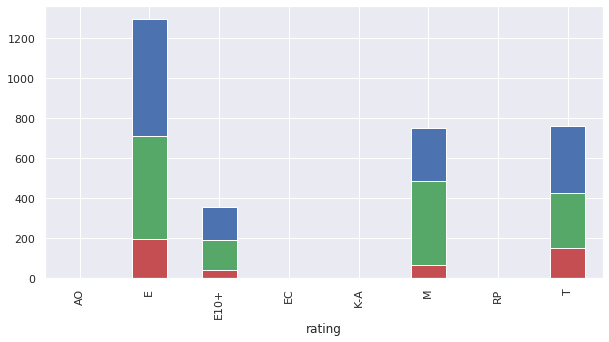

In [43]:
sns.set(rc={'figure.figsize':(10,5)})
games.query('~rating.isna()').groupby('rating')['na_sales'].sum().plot(kind = 'bar', color = 'b')
games.query('~rating.isna()').groupby('rating')['eu_sales'].sum().plot(kind = 'bar', color = 'g')
games.query('~rating.isna()').groupby('rating')['jp_sales'].sum().plot(kind = 'bar', color = 'r')

# В принципе влияние рейтинга схоже по рынкам за исключение игр 
# типа «M» («Mature») — «Для взрослых» на японском рынке, они продаются меньше чем в других странах. Культура ?

In [44]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,top_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,USA
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,USA
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,USA
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,USA
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,USA


**Шаг 5. Проверьте гипотезы**
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.
- Задайте самостоятельно пороговое значение alpha.
Поясните:
Как вы сформулировали нулевую и альтернативную гипотезы;
Какой критерий применили для проверки гипотез и почему.

In [45]:
# H0 = Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
# H1 = Средние пользовательские рейтинги платформ Xbox One и PC разные

xbox_score  = games.loc[(games['platform']=='XOne') & (~games['user_score'].isna()),'user_score']
pc_score  = games.loc[(games['platform']=='PC') & (~games['user_score'].isna()),'user_score']

alpha = .05 #критический уровень статистической значимости, считается достаточным такой порог

results = st.ttest_ind(xbox_score,pc_score)

print('p-value =',results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value = 1.2564860422127703e-05
Отвергаем нулевую гипотезу


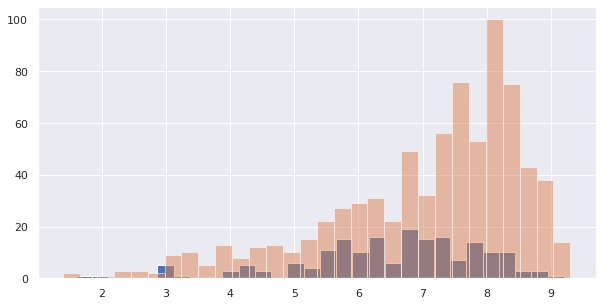

In [46]:
xbox_score.hist(bins=30)
pc_score.hist(bins=30, alpha = 0.5)

In [47]:
# H0 = Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.
# H1 = Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

action_score  = games.loc[(games['genre']=='Action') & (~games['user_score'].isna()),'user_score']
sport_score  = games.loc[(games['genre']=='Sports') & (~games['user_score'].isna()),'user_score']

alpha = .05 #критический уровень статистической значимости, считается достаточным такой порог

results = st.ttest_ind(action_score,sport_score)

print('p-value =',results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value = 0.14509898935411297
Не получилось отвергнуть нулевую гипотезу


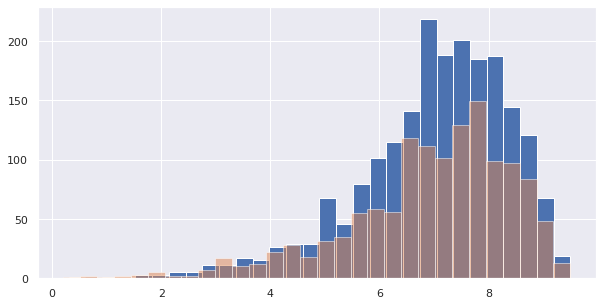

In [48]:
action_score.hist(bins=30)
sport_score.hist(bins=30, alpha = 0.5)

# Выводы по исследованию (шаг №5)
- Xbox популярнее в Северной Америке, оно и понятно Microsoft рядом
Европа предпочитает продукт Sony,  но и xbox немного уступает конкуренту ps3
- Рынок Японии весьма специфичен, лидируют карманная консоль ds +  в почете свой продукт от Sony. 
Удивительно, но в топ-5 в Японии нет xbox!
- рейтинги пользователей Xbox и PC разные
- рейтинги пользователей Action и Sport схожи статистически


# ИТОГ



# Выводы по исследованию (шаг №3)


- Видим в 2009 резкий провал,судя по всему началось значительное сокращение выпуска игр для: 
  Nintendo Wii и DS и старой линейки флагманов Sony PlayStation (PSP, PSP2, PSP3) и Microsoft Xbox (X360)
- Ожидаемо мы видим просадку по всем платформу в части выручки, она безусловно кореллирует с данными по выпускам игр
- Среднее время жизни консоли 7.22 лет
- Актуальный год - 2016
- Виден прирост продаж 2014/2015 по флагманам PS4 и XOne (18 и 11 % соответственно)
- Самые продаваемые многоплатформенные игры это Fifa 2014/2015
- В топе средний чек по играм для консолей первых поколений, т.к. по сути они "драйвили" рынок игр 
  (всеми любимый Dendy, Sega Mega Drive)
- Чем выше рейтинги - тем больше продаж, корреляция рейтингов критиков и пользоватлей =  0.58 (средняя)
- Рост продаж 2014-2015  виден только по жанрам (Shooter, Adventure, Strategy)
- Cамые продаваемые жанры это спорт, гонки и платформеры

# Выводы по исследованию (шаг №4)
- Средние пользовательские рейтинги платформ Xbox One и PC разные
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.

# Выводы по исследованию (шаг №5)
- Xbox популярнее в Северной Америке, оно и понятно Microsoft рядом
Европа предпочитает продукт Sony,  но и xbox немного уступает конкуренту ps3
- Рынок Японии весьма специфичен, лидируют карманная консоль ds +  в почете свой продукт от Sony. 
Удивительно, но в топ-5 в Японии нет xbox!
- рейтинги пользователей Xbox и PC разные
- рейтинги пользователей Action и Sport схожи статистически

# Общий вывод

1. Зафиксирован спад продаж в 2009 по всем консолям, во многом это обусловлено прекращением выпуска игр для консолей предыдущено поколения
2. Вместе с тем мы видим рост продаж в динамике 2014-2015 по ряду направлений (Shooter, Adventure, Strategy)
3. Хорошую динамику показывают консоли нового поколения Xbox One и Playstation. Это очевидный рост, т.к. данные консоли содержат в себе самое передовое железо и предназначено для новых игр

Если говорить о стратегии продаж для интернет-магазина «Стримчик» предлагаю сосредоточится на следующем:
- Европа и США/Канада продажа (Shooter, Adventure, Strategy) на консоли Xbox One/PS4
- Япония продажа в первую очередь ролевые игры, далее аналогично для рынка Европы на консоли DS и не смотря на очевидное устаревание поддерживать продуктовую корзину для PS/PS2/SNES